In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import joblib

In [3]:
data2 = pd.read_csv("Dataset.csv")

In [4]:
data2.head()

,Flight Number,Scheduled_Month,Scheduled_Year,Scheduled_Weekday,Delay (Minutes),Aircraft Utilization (Hours/Day),Turnaround Time (Minutes),Load Factor (%),Fleet Availability (%),Maintenance Downtime (Hours),Fuel Efficiency (ASK),Revenue (USD),Operating Cost (USD),Net Profit Margin (%),Ancillary Revenue (USD),Debt-to-Equity Ratio,Revenue per ASK,Cost per ASK,Profit (USD)
0,FL885,5,2024,1,50,12.36,115,79.18,96.24,9.21,4.15,10953.75,27847.59,17.90,1058.68,2.46,2639.46,6710.26,-16893.84
1,FL930,1,2024,2,27,14.53,83,98.59,80.49,1.55,3.93,31597.25,1564.41,7.70,2941.32,2.89,8040.01,398.07,30032.84
2,FL478,5,2024,4,108,10.73,87,67.44,97.90,2.06,4.26,13700.27,30494.88,5.84,1920.45,1.34,3216.03,7158.42,-16794.61
3,FL637,8,2024,4,64,15.10,99,69.01,80.17,6.85,4.13,39913.01,13444.09,24.09,3167.79,0.60,9664.17,3255.23,26468.92
4,FL318,7,2024,4,30,13.46,114,50.36,82.23,7.30,4.97,11531.48,34668.98,7.18,619.80,0.84,2320.22,6975.65,-23137.50


In [7]:
import warnings
warnings.filterwarnings('ignore')

class XGBPricePredictor:
    def __init__(self, params=None):
        # Default parameters if none provided
        self.default_params = {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_weight': 1,
            'gamma': 0,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'reg:squarederror',
            'random_state': 42
        }
        
        self.params = params if params is not None else self.default_params
        self.model = XGBRegressor(**self.params)
        self.history = {'train': {}, 'val': {}}
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, verbose=True, early_stopping_rounds=None):
        # Set metrics directly in the model parameters
        self.model.set_params(eval_metric=['rmse', 'mae'])
        
        # Prepare evaluation set
        eval_set = [(X_train, y_train)]
        eval_metric_names = ['rmse', 'mae']
        eval_names = ['train']
        
        if X_val is not None and y_val is not None:
            eval_set.append((X_val, y_val))
            eval_names.append('val')
        try:
            if early_stopping_rounds is not None:
                self.model.set_params(early_stopping_rounds=early_stopping_rounds)
            
            self.model.fit(
                X_train, y_train,
                eval_set=eval_set,
                verbose=verbose
            )
        except TypeError:
            kwargs = {
                'eval_set': eval_set,
                'verbose': verbose
            }
            if early_stopping_rounds is not None:
                kwargs['early_stopping_rounds'] = early_stopping_rounds
            
            try:
                self.model.fit(X_train, y_train, **kwargs)
            except TypeError:
                print("Warning: Could not use evaluation sets with this XGBoost version. Using basic fit.")
                self.model.fit(X_train, y_train)
        try:
            eval_results = self.model.evals_result()
            
            # Convert to our history format
            for i, name in enumerate(eval_names):
                eval_key = f"validation_{i}" if i > 0 else "validation_0"
                if eval_key in eval_results:
                    for metric, values in eval_results[eval_key].items():
                        if name not in self.history:
                            self.history[name] = {}
                        if metric not in self.history[name]:
                            self.history[name][metric] = []
                        self.history[name][metric] = values
        except:
            # If evals_result() is not available, create basic metrics manually
            print("Warning: Could not retrieve evaluation history. Metrics tracking may be limited.")
            y_pred_train = self.predict(X_train)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            mae_train = mean_absolute_error(y_train, y_pred_train)
            
            self.history['train']['rmse'] = [rmse_train]
            self.history['train']['mae'] = [mae_train]
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
                mae_val = mean_absolute_error(y_val, y_pred_val)
                
                self.history['val'] = {}
                self.history['val']['rmse'] = [rmse_val]
                self.history['val']['mae'] = [mae_val]
        
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'mape': mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
        }
        
        return metrics
    
    def tune_hyperparameters(self, X_train, y_train, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1):
        grid_search = GridSearchCV(
            XGBRegressor(),
            param_grid,
            cv=cv,
            scoring=scoring,
            verbose=verbose,
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        self.params = grid_search.best_params_
        self.model = XGBRegressor(**self.params)
        
        print(f"Best parameters found: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.4f}")
        
        return grid_search.best_params_
    
    def plot_training_history(self, figsize=(12, 5)):
        if not self.history['train']:
            print("No training history available. Please train the model first.")
            return
            
        # Determine how many metrics we have
        metrics = list(self.history['train'].keys())
        n_metrics = len(metrics)
        
        if n_metrics == 0:
            print("No metrics found in training history.")
            return
        
        # Create the appropriate number of subplots
        if n_metrics == 1:
            fig, ax = plt.subplots(figsize=figsize)
            axes = [ax]
        else:
            fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
            if n_metrics == 2:
                axes = list(axes)  # Ensure axes is a list for indexing
        
        for i, metric in enumerate(metrics):
            ax = axes[i] if n_metrics > 1 else axes
            
            # Plot training metric
            ax.plot(self.history['train'][metric], label=f'Training {metric}')
            
            # Plot validation metric if available
            if 'val' in self.history and metric in self.history['val']:
                ax.plot(self.history['val'][metric], label=f'Validation {metric}')
            
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric.upper())
            ax.set_title(f'{metric.upper()} over epochs')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, feature_names=None, figsize=(10, 6), top_n=None):
        importances = self.model.feature_importances_
        
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(importances))]
        
        # Create a DataFrame for easier sorting and plotting
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        if top_n is not None:
            importance_df = importance_df.head(top_n)
        
        plt.figure(figsize=figsize)
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self, X, y_true, figsize=(10, 6)):
        y_pred = self.predict(X)
        
        plt.figure(figsize=figsize)
        plt.scatter(y_true, y_pred, alpha=0.5)
        
        # Plot the perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def get_residuals_plot(self, X, y_true, figsize=(10, 6)):
        y_pred = self.predict(X)
        residuals = y_true - y_pred
        
        plt.figure(figsize=figsize)
        
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Also show residual distribution
        plt.figure(figsize=figsize)
        sns.histplot(residuals, kde=True)
        plt.xlabel('Residuals')
        plt.title('Residual Distribution')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    X = data2.drop(["Profit (USD)", "Flight Number", "Scheduled_Year", "Scheduled_Weekday", "Scheduled_Month"], axis = 1)
    y = data2["Profit (USD)"]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Example of hyperparameter tuning
    param_grid = {
        'n_estimators': 200,
        'learning_rate': 0.1,
        'max_depth': 7,
        'min_child_weight': 1,
        'gamma': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # Initialize and train model with default parameters
    xgb_model = XGBPricePredictor(params=param_grid)
    xgb_model.fit(X_train, y_train, X_val=X_val, y_val=y_val)
    
    # Evaluate model
    train_metrics = xgb_model.evaluate(X_train, y_train)
    test_metrics = xgb_model.evaluate(X_test, y_test)
    
    
    
    # Uncomment to run hyperparameter tuning (can be time-consuming)
    #best_params = xgb_model.tune_hyperparameters(X_train, y_train, param_grid, cv=3)

[0]	validation_0-rmse:17056.26196	validation_0-mae:13955.15770	validation_1-rmse:17043.40965	validation_1-mae:13942.68797
[1]	validation_0-rmse:15408.49356	validation_0-mae:12595.97474	validation_1-rmse:15397.31213	validation_1-mae:12584.65142
[2]	validation_0-rmse:13885.01123	validation_0-mae:11349.48118	validation_1-rmse:13877.47243	validation_1-mae:11341.68272
[3]	validation_0-rmse:12513.28930	validation_0-mae:10226.95649	validation_1-rmse:12508.23629	validation_1-mae:10222.51680
[4]	validation_0-rmse:11311.08636	validation_0-mae:9234.14168	validation_1-rmse:11308.26540	validation_1-mae:9232.28894
[5]	validation_0-rmse:10194.38635	validation_0-mae:8322.36153	validation_1-rmse:10192.64039	validation_1-mae:8322.11752
[6]	validation_0-rmse:9188.07043	validation_0-mae:7499.26463	validation_1-rmse:9187.76416	validation_1-mae:7500.19861
[7]	validation_0-rmse:8282.58207	validation_0-mae:6758.77053	validation_1-rmse:8282.53832	validation_1-mae:6760.56299
[8]	validation_0-rmse:7465.65890	val

## *After training we get our metrice of Train and Test data*

In [8]:
print("Training metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
    
print("\nTest metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Training metrics:
rmse: 218.9507
mae: 171.2917
r2: 0.9999
mape: 22.2410

Test metrics:
rmse: 245.1456
mae: 191.2006
r2: 0.9998
mape: 9.6802


In [15]:
joblib.dump(xgb_model, 'model.pkl')
print("Model dumped!")

Model dumped!


### Below two are graphs for RMSE over epochs and MAE over epochs

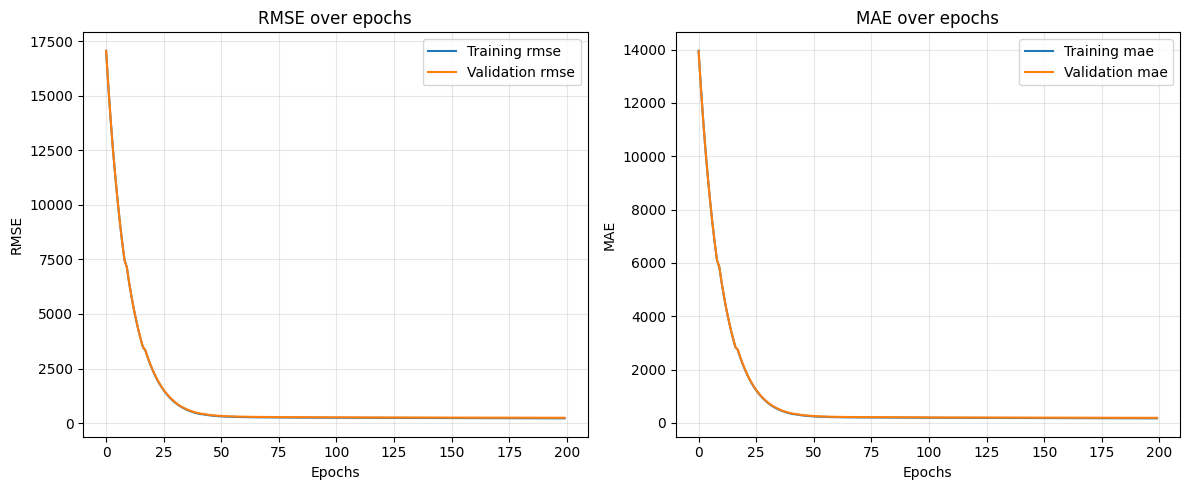

In [9]:
# Plot training history
xgb_model.plot_training_history()

### The graph below provides us which features are important for us from the given dataset

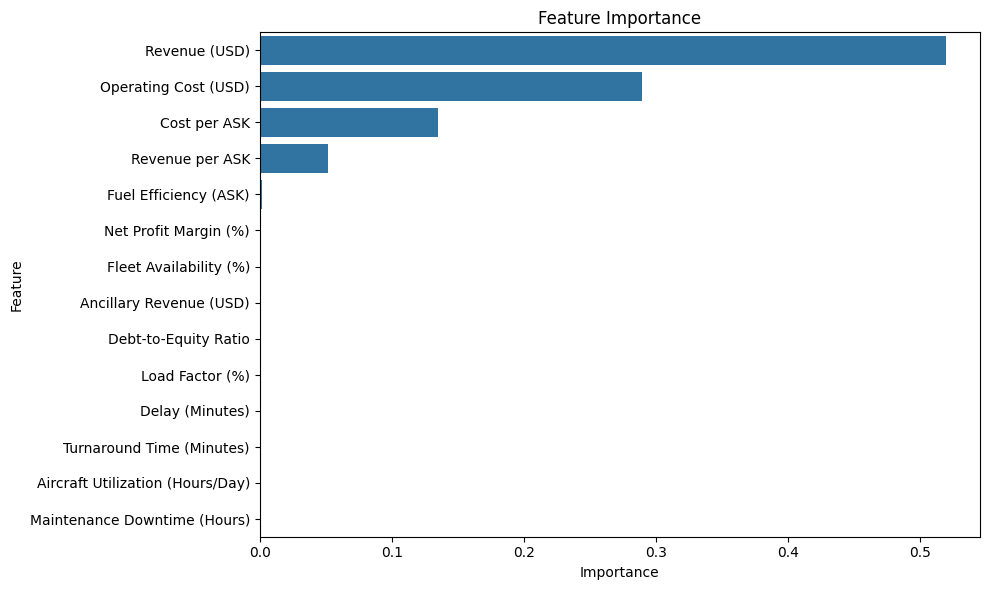

In [10]:
# Plot feature importance
xgb_model.plot_feature_importance(feature_names=X.columns)

### The below graph shows how our model works on Actual vs Predicted Values

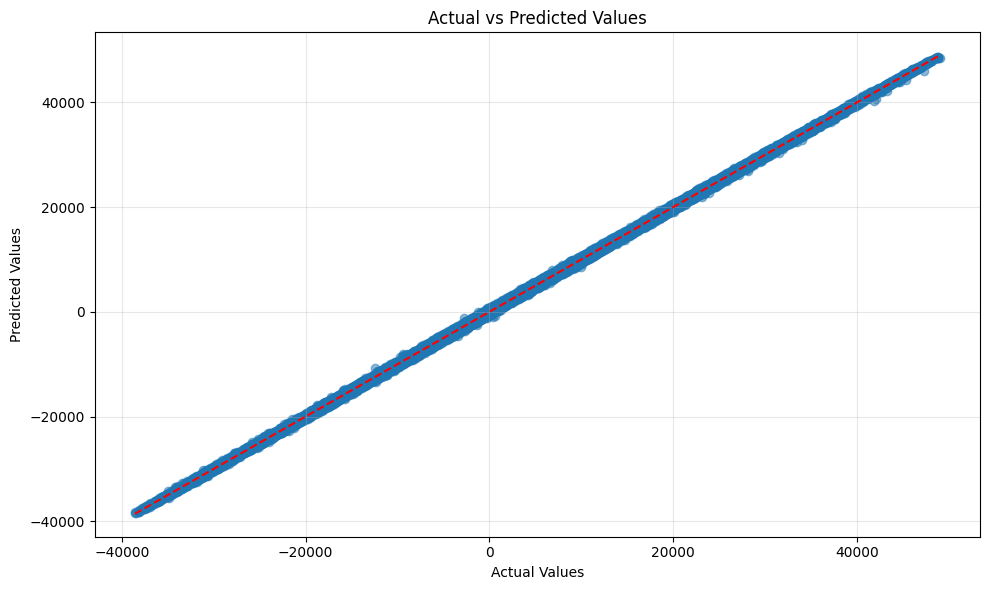

In [11]:
# Plot predictions
xgb_model.plot_predictions(X_test, y_test)

### The below two graphs are the residual plot on unseen data

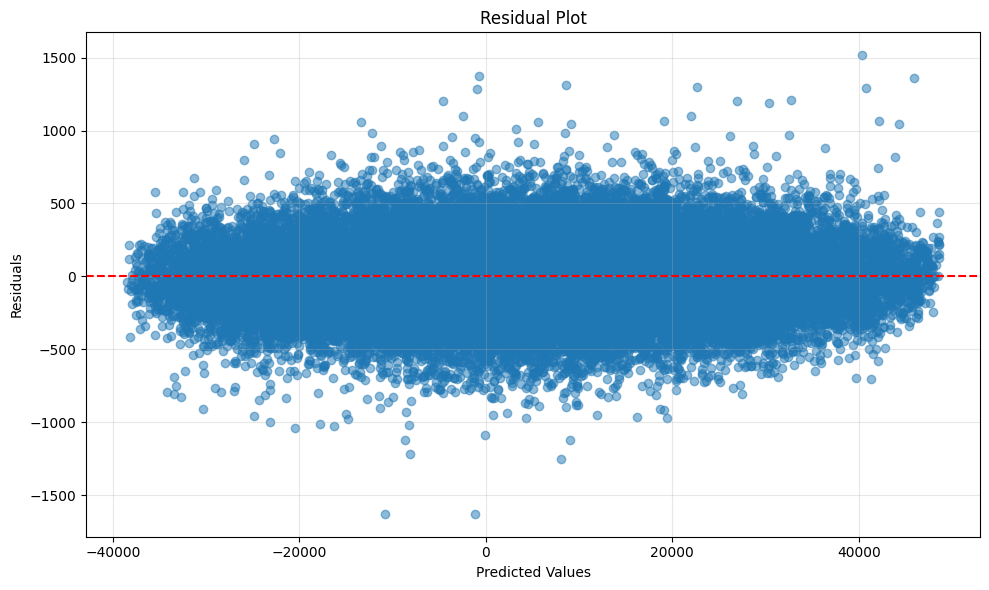

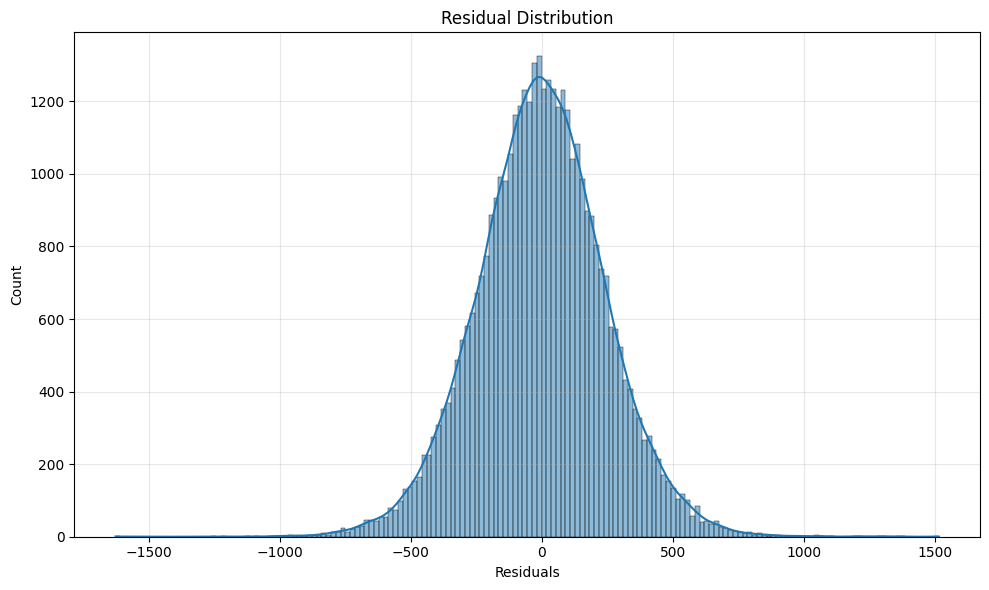

In [12]:
# Plot residuals
xgb_model.get_residuals_plot(X_test, y_test)

### Test our model on Unseen Paramters yourself

In [13]:
xgb_model = XGBPricePredictor()
xgb_model.fit(X_train, y_train)
array = np.array([[50,12.36,115,79.18,96.24,9.21,4.15,10953.75,27847.59,17.90,1058.68,2.46,2639.46,6710.26]])
prediction = xgb_model.predict(array)

[0]	validation_0-rmse:17059.78165	validation_0-mae:13957.87125
[1]	validation_0-rmse:15486.11635	validation_0-mae:12661.57399
[2]	validation_0-rmse:14000.38026	validation_0-mae:11444.32495
[3]	validation_0-rmse:12663.22345	validation_0-mae:10346.75388
[4]	validation_0-rmse:11513.24637	validation_0-mae:9400.42495
[5]	validation_0-rmse:10416.41008	validation_0-mae:8503.19332
[6]	validation_0-rmse:9424.85493	validation_0-mae:7689.23710
[7]	validation_0-rmse:8529.79128	validation_0-mae:6959.14533
[8]	validation_0-rmse:7719.37920	validation_0-mae:6288.46192
[9]	validation_0-rmse:7374.91024	validation_0-mae:6021.42965
[10]	validation_0-rmse:6676.30651	validation_0-mae:5450.50692
[11]	validation_0-rmse:6077.47721	validation_0-mae:4951.92013
[12]	validation_0-rmse:5503.60085	validation_0-mae:4482.63221
[13]	validation_0-rmse:5014.88953	validation_0-mae:4077.48885
[14]	validation_0-rmse:4544.95557	validation_0-mae:3691.15556
[15]	validation_0-rmse:4121.98049	validation_0-mae:3346.43226
[16]	val

In [14]:
print(f"The prediction provided by our model is {prediction[0]:.2f}")

The prediction provided by our model is -16855.05


### A better way to try yourself tune hyperparameters and a better way to predict using our model visit :
[Neural Ninjas](https://neuralninjas.bhaweshagrawal.com.np)